## Example 1: U.S. Public Spending on Construction from 2002 - 2014. 

Source: U.S. Census Bureau

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Load and generate initial graph

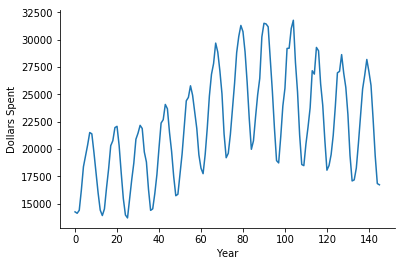

In [2]:
dfPuC= pd.read_csv('ConstructionTimeSeriesDatav2.csv')
del dfPuC['Private Construction']
del dfPuC['Total Construction']
del dfPuC['Month']

fig,ax = plt.subplots()
ax.plot(dfPuC['Public Construction'],label='Public Construction')
ax.set_xlabel('Year')
ax.set_ylabel('Dollars Spent')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

The data displays a non-linear trend. 

In [3]:
dfPuC.head()

,Month-Year,Public Construction
0,2-Jan,14243
1,2-Feb,14113
2,2-Mar,14386
3,2-Apr,16221
4,2-May,18375


Adjust the window variable to find the smallest average squared error per month. 

C:\Users\megan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  import sys
C:\Users\megan\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Average Squared Error per Month:  4804532.005915987
           Month-Year  Public Construction      MovAvg         sqErr
2002-05-31      2-May                18375  17770.7500  3.651181e+05
2002-06-30      2-Jun                19381  18565.5000  6.650402e+05
2002-07-31      2-Jul                20369  19127.8750  1.540391e+06
2002-08-31      2-Aug                21507  19325.6250  4.758397e+06
2002-09-30      2-Sep                21385  19061.1875  5.400105e+06
2002-10-31      2-Oct                19687  18470.8125  1.479112e+06
2002-11-30      2-Nov                17810  17762.4375  2.262191e+03
2002-12-31      2-Dec                15961  17079.8125  1.251741e+06
2003-01-31      3-Jan                14404  16563.5000  4.663440e+06
2003-02-28      3-Feb                13906  16402.0000  6.230016e+06
2003-03-31      3-Mar                14510  16624.4375  4.470846e+06
2003-04-30      3-Apr                16444  17183.2500  5.464906e+05
2003-05-31      3-May                18187  18037.4

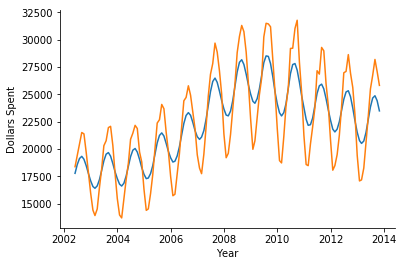

In [4]:
def sqErr(row): 
    return(row['Public Construction'] - row['MovAvg'])**2

dfPuC['MovAvg'] = np.NaN
dfPuC['sqErr'] = np.NaN

dfPuC.index = pd.DatetimeIndex(freq = 'm', start=pd.Timestamp(year=2002, month=1,day=31), periods = len(dfPuC['Public Construction']))
window = 8
window = window - window % 2 
for i in range(int(window/2),dfPuC.shape[0]-int(window/2)):
    dfPuC.loc[dfPuC.index[i], 'MovAvg'] = (0.5*dfPuC.iloc[i - int(window/2)]['Public Construction'] + dfPuC.iloc[i - int(window/2)+1:i + int(window/2)]['Public Construction'].sum() + 0.5*dfPuC.iloc[i + int(window/2)]['Public Construction'])/float(window)
dfPuC['sqErr'] = (dfPuC['Public Construction'] - dfPuC['MovAvg'])**2 
dfPuC.dropna(how='any', inplace=True)


fig,ax = plt.subplots()
ax.plot(dfPuC['MovAvg'],label='Moving Avg.')
ax.plot(dfPuC['Public Construction'],label='Public Construction')
ax.set_xlabel('Year')
ax.set_ylabel('Dollars Spent')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
print('Average Squared Error per Month: ',sum(dfPuC['sqErr'])/len(dfPuC))
print(dfPuC)

Compute R1 as a percentage of demand (R1Error) 

In [5]:
dfPuC['R1'] = dfPuC['Public Construction'] - dfPuC['MovAvg']
dfPuC['R1Error'] = abs((dfPuC['Public Construction'] - dfPuC['R1'])/dfPuC['Public Construction'])
dfPuC.style.format({
    'MovAvg': '{:.1f}'.format,
    'sqErr': '{:,.1f}'.format,
    'R1': '{:,.1f}'.format,
    'R1Error': '{:,.3f}'.format
})

,Month-Year,Public Construction,MovAvg,sqErr,R1,R1Error
2002-05-31 00:00:00,2-May,18375,17770.8,"365,118.1",604.2,0.967
2002-06-30 00:00:00,2-Jun,19381,18565.5,"665,040.2",815.5,0.958
2002-07-31 00:00:00,2-Jul,20369,19127.9,"1,540,391.3","1,241.1",0.939
2002-08-31 00:00:00,2-Aug,21507,19325.6,"4,758,396.9","2,181.4",0.899
2002-09-30 00:00:00,2-Sep,21385,19061.2,"5,400,104.5","2,323.8",0.891
2002-10-31 00:00:00,2-Oct,19687,18470.8,"1,479,112.0","1,216.2",0.938
2002-11-30 00:00:00,2-Nov,17810,17762.4,"2,262.2",47.6,0.997
2002-12-31 00:00:00,2-Dec,15961,17079.8,"1,251,741.4","-1,118.8",1.070
2003-01-31 00:00:00,3-Jan,14404,16563.5,"4,663,440.2","-2,159.5",1.150
2003-02-28 00:00:00,3-Feb,13906,16402.0,"6,230,016.0","-2,496.0",1.179


In [ ]:
The average residual pattern is displayed in this graph. 

Average Residual:  77.15534420289855


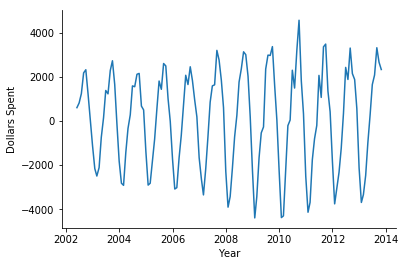

In [6]:
fig,ax = plt.subplots()
ax.plot(dfPuC['R1'])
ax.set_xlabel('Year')
ax.set_ylabel('Dollars Spent')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
print('Average Residual: ', sum(dfPuC['R1'])/len(dfPuC))


The autocorrelation analysis calculates cyclical patterns and frequency of periods before they are repeated. 

In [7]:
maxCorr = 0.0
period = np.NaN
for i in range(1,9):
    corr = dfPuC['R1'].autocorr(lag=i)
    print('Correlation, lag ',i,'   ',corr)
    if corr > maxCorr:
        maxCorr = corr
        period = i
print('period = ',period,'     Maximum Correlation = ',maxCorr)

Correlation, lag  1     0.8178825753949032
Correlation, lag  2     0.4514319840219928
Correlation, lag  3     -0.01675388433054715
Correlation, lag  4     -0.47807068702459515
Correlation, lag  5     -0.7804856136756246
Correlation, lag  6     -0.8884928154090952
Correlation, lag  7     -0.7942070785080088
Correlation, lag  8     -0.4971406597021781
period =  1      Maximum Correlation =  0.8178825753949032


The code below plots the average cycle versus the 4 cycle instances within the data. 

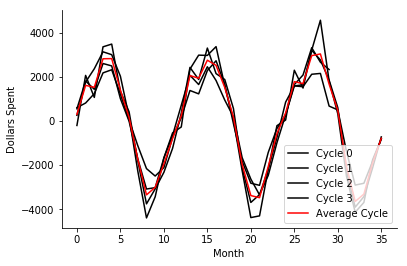

In [8]:
period = 36
cycleLen = period
numCycles = int(len(dfPuC)/cycleLen + 0.5)
cycles = [dfPuC.iloc[range(i*period,min((i+1)*period,len(dfPuC)))]['R1'] for i in range(numCycles)]
ptsInCycles = [dfPuC.iloc[range(i,len(dfPuC['R1']),period)]['R1'].tolist() for i in range(period)]
avg = [sum(pts)/len(pts) for pts in ptsInCycles]

fig,ax = plt.subplots()
for i in range(len(cycles)):
    ax.plot(cycles[i].values,label='Cycle '+str(i),c='k')
ax.plot(avg,label='Average Cycle',c='r')
ax.set_xlabel('Month')
ax.set_ylabel('Dollars Spent')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

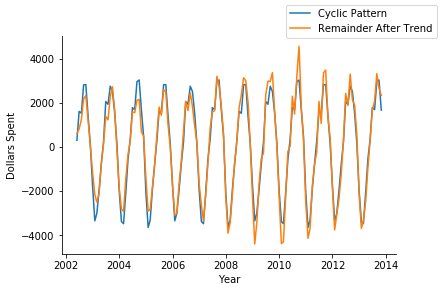

In [9]:
cycleLen = period   # see prior cell for computation of cyclicality period
numCycles = int(len(dfPuC)/cycleLen + 0.5)
dfPuC['C'] = np.NaN   # Creates an empty column for the cyclicality component data
for i in range(len(dfPuC)):
    dfPuC.loc[dfPuC.index[i], 'C'] = avg[i % cycleLen] # Write appropriate cyclicality value

fig,ax = plt.subplots()
ax.plot(dfPuC['C'],label='Cyclic Pattern')
ax.plot(dfPuC['R1'],label='Remainder After Trend')
ax.set_xlabel('Year')
ax.set_ylabel('Dollars Spent')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()

Average Error:  0.01656178814557039
           Month-Year  Public Construction      MovAvg         R1   R1Error  \
2002-05-31      2-May                18375  17770.7500   604.2500  0.967116   
2002-06-30      2-Jun                19381  18565.5000   815.5000  0.957923   
2002-07-31      2-Jul                20369  19127.8750  1241.1250  0.939068   
2002-08-31      2-Aug                21507  19325.6250  2181.3750  0.898574   
2002-09-30      2-Sep                21385  19061.1875  2323.8125  0.891334   
2002-10-31      2-Oct                19687  18470.8125  1216.1875  0.938224   
2002-11-30      2-Nov                17810  17762.4375    47.5625  0.997329   
2002-12-31      2-Dec                15961  17079.8125 -1118.8125  1.070097   
2003-01-31      3-Jan                14404  16563.5000 -2159.5000  1.149924   
2003-02-28      3-Feb                13906  16402.0000 -2496.0000  1.179491   
2003-03-31      3-Mar                14510  16624.4375 -2114.4375  1.145723   
2003-04-30      

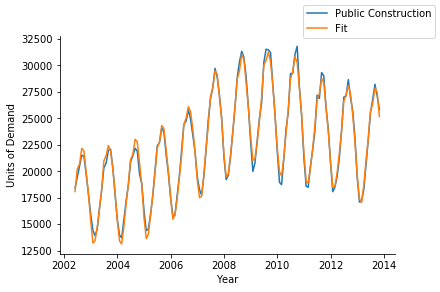

In [10]:
dfPuC['R2Public'] = dfPuC['R1'] - dfPuC['C']
dfPuC['R2ErrorPublic'] = abs(dfPuC['R2Public']/dfPuC['Public Construction'])
dfPuC['fit'] = dfPuC['MovAvg'] + dfPuC['C']
dfPuC.drop(['sqErr'],axis=1,inplace=True)
print('Average Error: ', sum(dfPuC['R2ErrorPublic'])/len(dfPuC))
print(dfPuC)
fig,ax = plt.subplots()
ax.plot(dfPuC['Public Construction'],label='Public Construction')
ax.plot(dfPuC['fit'], label = 'Fit')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()

Correlation, lag  1     0.3801353240820756
Correlation, lag  2     0.10103925677824109
Correlation, lag  3     -0.04355329070766006
Correlation, lag  4     -0.3207897798517599
Correlation, lag  5     -0.3189587026869027
Correlation, lag  6     -0.37996518602908724
Correlation, lag  7     -0.4779723018370897
Correlation, lag  8     -0.2540791037711258
Correlation, lag  9     0.0508845801190877
Correlation, lag  10     -0.001963119272705685
Correlation, lag  11     0.34863556710587895
Correlation, lag  12     0.5358881690310962
Correlation, lag  13     0.22477866222993648
Correlation, lag  14     0.39351213328362034
Correlation, lag  15     0.0588303761363151
Correlation, lag  16     -0.13484902143129232
Correlation, lag  17     -0.11555438945487152
Correlation, lag  18     -0.2927277798590681
Correlation, lag  19     -0.4429675914105643
Correlation, lag  20     -0.2986169424520758
Correlation, lag  21     -0.2098983488865788
Correlation, lag  22     -0.060219256945257545
Correlation, la

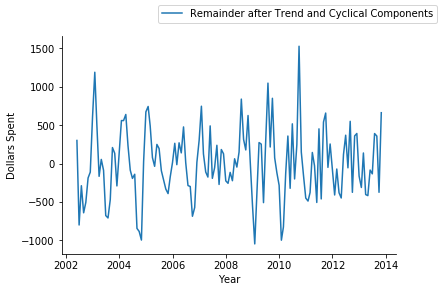

In [11]:
fig,ax = plt.subplots()
ax.plot(dfPuC['R2Public'],label='Remainder after Trend and Cyclical Components')
ax.set_xlabel('Year')
ax.set_ylabel('Dollars Spent')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()
maxCorr = 0.0
period = np.NaN
for i in range(1,29):
    corr = dfPuC['R2Public'].autocorr(lag=i)
    print('Correlation, lag ',i,'   ',corr)
    if corr > maxCorr:
        maxCorr = corr
        period = i
print('period = ',period,'     Maximum Correlation = ',maxCorr)

The below final graph plots the model versus the original data and the remainder R2 to judge if it is relative to the original data we were trying to fit. Model looks to fit the original data pretty well. 

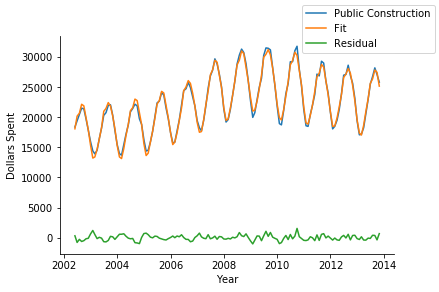

In [12]:
fig,ax = plt.subplots()
ax.plot(dfPuC['Public Construction'],label='Public Construction')
ax.plot(dfPuC['fit'],label='Fit')
ax.plot(dfPuC['R2Public'],label='Residual')
ax.set_xlabel('Year')
ax.set_ylabel('Dollars Spent')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()

## Example 2: U.S. Private Spending on Construction from 2002 - 2014. 

Source: U.S. Census Bureau

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Import and initialize data 

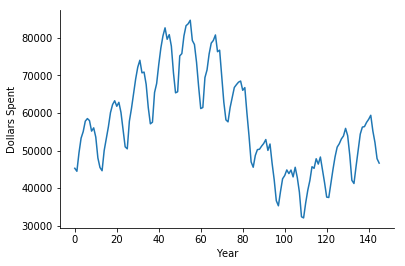

In [14]:
dfPr= pd.read_csv('ConstructionTimeSeriesDatav2.csv')
del dfPr['Public Construction']
del dfPr['Total Construction']
del dfPr['Month']

fig,ax = plt.subplots()
ax.plot(dfPr['Private Construction'],label='Private Construction')
ax.set_xlabel('Year')
ax.set_ylabel('Dollars Spent')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

The data has a nonlinear trend. 

Adjust the window variable to find the appropriate size for the moving average. 

C:\Users\megan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  import sys


Average Squared Error per Month:  2874967.9933978873
           Month-Year  Private Construction     MovAvg         sqErr
2002-03-31      2-Mar                 49396  49323.750  5.220062e+03
2002-04-30      2-Apr                 53283  52206.500  1.158852e+06
2002-05-31      2-May                 55009  55009.500  2.500000e-01
2002-06-30      2-Jun                 57801  56730.500  1.145970e+06
2002-07-31      2-Jul                 58494  57332.750  1.348502e+06
2002-08-31      2-Aug                 57953  57129.000  6.789760e+05
2002-09-30      2-Sep                 55157  56289.000  1.281424e+06
2002-10-31      2-Oct                 56023  54430.000  2.537649e+06
2002-11-30      2-Nov                 53552  51978.250  2.476689e+06
2002-12-31      2-Dec                 48023  49342.375  1.740750e+06
2003-01-31      3-Jan                 45473  47472.500  3.998000e+06
2003-02-28      3-Feb                 44620  47674.500  9.329970e+06
2003-03-31      3-Mar                 49996  49672

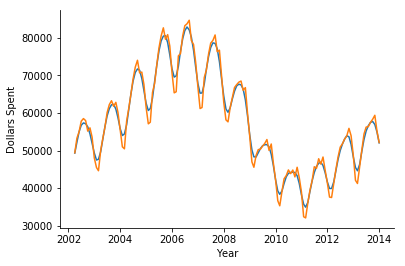

In [15]:
def sqErr(row): 
    return(row['Private Construction'] - row['MovAvg'])**2

dfPr['MovAvg'] = np.NaN
dfPr['sqErr'] = np.NaN

dfPr.index = pd.DatetimeIndex(freq = 'm', start=pd.Timestamp(year=2002, month=1,day=31), periods = len(dfPr['Private Construction']))
window = 4
window = window - window % 2 
for i in range(int(window/2),dfPr.shape[0]-int(window/2)):
    dfPr.loc[dfPr.index[i], 'MovAvg'] = (0.5*dfPr.iloc[i - int(window/2)]['Private Construction'] + dfPr.iloc[i - int(window/2)+1:i + int(window/2)]['Private Construction'].sum() + 0.5*dfPr.iloc[i + int(window/2)]['Private Construction'])/float(window)
dfPr['sqErr'] = (dfPr['Private Construction'] - dfPr['MovAvg'])**2 
dfPr.dropna(how='any', inplace=True)


fig,ax = plt.subplots()
ax.plot(dfPr['MovAvg'],label='Moving Avg.')
ax.plot(dfPr['Private Construction'],label='Private Construction')
ax.set_xlabel('Year')
ax.set_ylabel('Dollars Spent')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
print('Average Squared Error per Month: ',sum(dfPr['sqErr'])/len(dfPr))
print(dfPr)

Calculate the R1 Error by subtracting the moving average from the original time series. 

In [16]:
dfPr['R1'] = dfPr['Private Construction'] - dfPr['MovAvg']
dfPr['R1Error'] = abs((dfPr['Private Construction'] - dfPr['R1'])/dfPr['Private Construction'])
dfPr.style.format({
    'MovAvg': '{:.1f}'.format,
    'sqErr': '{:,.1f}'.format,
    'R1': '{:,.1f}'.format,
    'R1Error': '{:,.3f}'.format
})

,Month-Year,Private Construction,MovAvg,sqErr,R1,R1Error
2002-03-31 00:00:00,2-Mar,49396,49323.8,"5,220.1",72.2,0.999
2002-04-30 00:00:00,2-Apr,53283,52206.5,"1,158,852.2","1,076.5",0.980
2002-05-31 00:00:00,2-May,55009,55009.5,0.2,-0.5,1.000
2002-06-30 00:00:00,2-Jun,57801,56730.5,"1,145,970.2","1,070.5",0.981
2002-07-31 00:00:00,2-Jul,58494,57332.8,"1,348,501.6","1,161.2",0.980
2002-08-31 00:00:00,2-Aug,57953,57129.0,"678,976.0",824.0,0.986
2002-09-30 00:00:00,2-Sep,55157,56289.0,"1,281,424.0","-1,132.0",1.021
2002-10-31 00:00:00,2-Oct,56023,54430.0,"2,537,649.0","1,593.0",0.972
2002-11-30 00:00:00,2-Nov,53552,51978.2,"2,476,689.1","1,573.8",0.971
2002-12-31 00:00:00,2-Dec,48023,49342.4,"1,740,750.4","-1,319.4",1.027


The code below graphs the remaining pattern to be decomposed. R1 calculates the average residual pattern. The graph supports a nonlinear model. 

Average Residual:  38.936619718309856


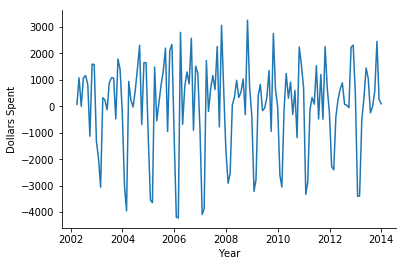

In [17]:
fig,ax = plt.subplots()
ax.plot(dfPr['R1'])
ax.set_xlabel('Year')
ax.set_ylabel('Dollars Spent')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
print('Average Residual: ', sum(dfPr['R1'])/len(dfPr))

The autocorrelation analysis calculates cyclical patterns and frequency of periods before they are repeated. 

In [18]:
maxCorr = 0.0
period = np.NaN
for i in range(1,9):
    corr = dfPr['R1'].autocorr(lag=i)
    print('Correlation, lag ',i,'   ',corr)
    if corr > maxCorr:
        maxCorr = corr
        period = i
print('period = ',period,'     Maximum Correlation = ',maxCorr)

Correlation, lag  1     0.3001325358380456
Correlation, lag  2     -0.08682789486998586
Correlation, lag  3     -0.277039413095538
Correlation, lag  4     -0.14947788930233938
Correlation, lag  5     -0.07780568356479374
Correlation, lag  6     -0.340807916085792
Correlation, lag  7     -0.08512695203907214
Correlation, lag  8     -0.17149339646739847
period =  1      Maximum Correlation =  0.3001325358380456


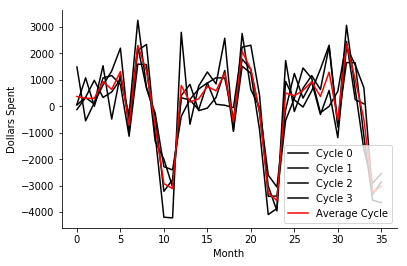

In [19]:
period = 36
cycleLen = period
numCycles = int(len(dfPr)/cycleLen + 0.5)
cycles = [dfPr.iloc[range(i*period,min((i+1)*period,len(dfPr)))]['R1'] for i in range(numCycles)]
ptsInCycles = [dfPr.iloc[range(i,len(dfPr['R1']),period)]['R1'].tolist() for i in range(period)]
avg = [sum(pts)/len(pts) for pts in ptsInCycles]

fig,ax = plt.subplots()
for i in range(len(cycles)):
    ax.plot(cycles[i].values,label='Cycle '+str(i),c='k')
ax.plot(avg,label='Average Cycle',c='r')
ax.set_xlabel('Month')
ax.set_ylabel('Dollars Spent')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

Next step is to see how the R1 calculations and the cyclicality components match up.

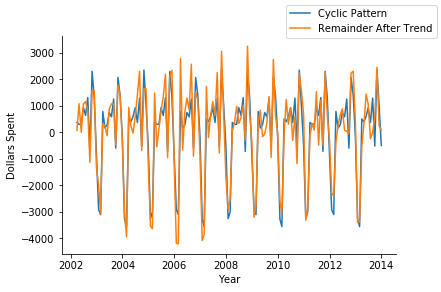

In [20]:
cycleLen = period   # see prior cell for computation of cyclicality period
numCycles = int(len(dfPr)/cycleLen + 0.5)
dfPr['C'] = np.NaN   # Creates an empty column for the cyclicality component data
for i in range(len(dfPr)):
    dfPr.loc[dfPr.index[i], 'C'] = avg[i % cycleLen] # Write appropriate cyclicality value

fig,ax = plt.subplots()
ax.plot(dfPr['C'],label='Cyclic Pattern')
ax.plot(dfPr['R1'],label='Remainder After Trend')
ax.set_xlabel('Year')
ax.set_ylabel('Dollars Spent')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()

The below code calculates the error of my model compared to the original data series and computes the R2ErrorPrivate that shows the error divided by the oringal data series.

Average Error:  0.009132674024474194
           Month-Year  Private Construction     MovAvg        R1   R1Error  \
2002-03-31      2-Mar                 49396  49323.750    72.250  0.998537   
2002-04-30      2-Apr                 53283  52206.500  1076.500  0.979797   
2002-05-31      2-May                 55009  55009.500    -0.500  1.000009   
2002-06-30      2-Jun                 57801  56730.500  1070.500  0.981480   
2002-07-31      2-Jul                 58494  57332.750  1161.250  0.980148   
2002-08-31      2-Aug                 57953  57129.000   824.000  0.985782   
2002-09-30      2-Sep                 55157  56289.000 -1132.000  1.020523   
2002-10-31      2-Oct                 56023  54430.000  1593.000  0.971565   
2002-11-30      2-Nov                 53552  51978.250  1573.750  0.970613   
2002-12-31      2-Dec                 48023  49342.375 -1319.375  1.027474   
2003-01-31      3-Jan                 45473  47472.500 -1999.500  1.043971   
2003-02-28      3-Feb      

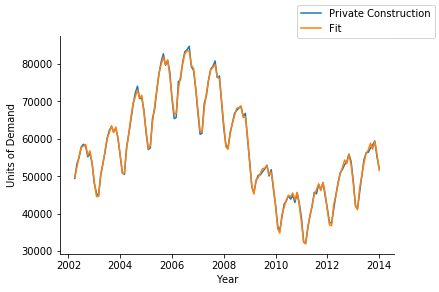

In [21]:
dfPr['R2Private'] = dfPr['R1'] - dfPr['C']
dfPr['R2ErrorPrivate'] = abs(dfPr['R2Private']/dfPr['Private Construction'])
dfPr['fit'] = dfPr['MovAvg'] + dfPr['C']
dfPr.drop(['sqErr'],axis=1,inplace=True)
print('Average Error: ', sum(dfPr['R2ErrorPrivate'])/len(dfPr))
print(dfPr)
fig,ax = plt.subplots()
ax.plot(dfPr['Private Construction'],label='Private Construction')
ax.plot(dfPr['fit'], label = 'Fit')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()

Correlation, lag  1     -0.14962830170780142
Correlation, lag  2     -0.15260703037317047
Correlation, lag  3     -0.08355231456792643
Correlation, lag  4     0.04565399167435087
Correlation, lag  5     -0.09257009720255147
Correlation, lag  6     -0.1778472460827814
Correlation, lag  7     -0.017296208242508267
Correlation, lag  8     0.07717604498385795
Correlation, lag  9     -0.09332883836681802
Correlation, lag  10     -0.03618796339503342
Correlation, lag  11     -0.038755989651493385
Correlation, lag  12     0.48972783095651395
Correlation, lag  13     -0.14598338509761366
Correlation, lag  14     0.05044774061818232
Correlation, lag  15     -0.07634583864991222
Correlation, lag  16     0.05518180310234261
Correlation, lag  17     -0.10221406028993998
Correlation, lag  18     -0.1766662268775961
Correlation, lag  19     0.015553782849144944
Correlation, lag  20     0.14721136572719173
Correlation, lag  21     -0.07131389952415135
Correlation, lag  22     -0.11365343900616708
Cor

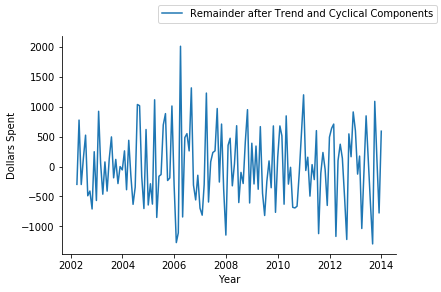

In [22]:
fig,ax = plt.subplots()
ax.plot(dfPr['R2Private'],label='Remainder after Trend and Cyclical Components')
ax.set_xlabel('Year')
ax.set_ylabel('Dollars Spent')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()
maxCorr = 0.0
period = np.NaN
for i in range(1,37):
    corr = dfPr['R2Private'].autocorr(lag=i)
    print('Correlation, lag ',i,'   ',corr)
    if corr > maxCorr:
        maxCorr = corr
        period = i
print('period = ',period,'     Maximum Correlation = ',maxCorr)

The final graph displays the accuracy of the model compared to the original data. 

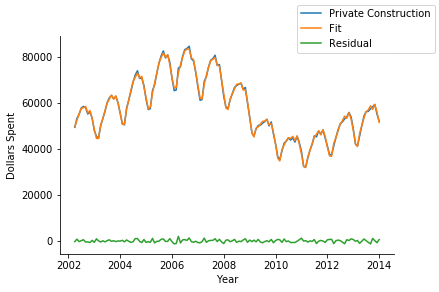

In [23]:
fig,ax = plt.subplots()
ax.plot(dfPr['Private Construction'],label='Private Construction')
ax.plot(dfPr['fit'],label='Fit')
ax.plot(dfPr['R2Private'],label='Residual')
ax.set_xlabel('Year')
ax.set_ylabel('Dollars Spent')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()